# GEOG5404 Policy briefing and data science notebook

## Data Description and Visualisation <br>


### Modules & Packages

In [1]:
import glob  # For file path operations
import numpy as np
import pandas as pd
import xarray as xr  # Handles multi-dimensional datasets
import seaborn as sns  # For statistical data visualization
import geopandas as gpd
import matplotlib as mpl
import cartopy.crs as ccrs  # For geographic projections
import matplotlib.pyplot as plt
import cartopy.feature as cfeature  # Adds geographic features like borders
from adjustText import adjust_text  # Adjusts text labels to avoid overlap
from matplotlib.cm import ScalarMappable, get_cmap  # Maps data values to colors
from matplotlib.colors import (
    LinearSegmentedColormap,
    Normalize,
)  # Normalizes data values for colormap scaling
from sklearn.preprocessing import StandardScaler
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

In [2]:
# Define a custom colormap for visualization
base_colors = [
     '#a1d1a8', '#8ac79b', '#77c092', '#64b693','#52ab99',
     '#439a9c', '#3a829a', '#336b96', '#305d86', '#2e4e77'
]

def get_color_palette(n_colors, reverse=True):
    cmap = LinearSegmentedColormap.from_list('my_cmap', base_colors, N=n_colors)
    palette = [mpl.colors.rgb2hex(cmap(i/(n_colors-1))) for i in range(n_colors)]
    if reverse:
        palette = palette[::-1]
    return palette

def get_cmap(reverse=False):
    # 返回matplotlib的Colormap对象，scatter可用
    colors = base_colors[::-1] if reverse else base_colors
    return LinearSegmentedColormap.from_list('my_cmap', colors, N=256)

### Data 1: Flight Data


In [3]:
file_paths = glob.glob("flightlist/flight_list_202*.parquet")

all_flights = []

for file_path in file_paths:
    data = pd.read_parquet(file_path)
    all_flights.append(data)
flights = pd.concat(all_flights, ignore_index=True)

flights.head()

,id,icao24,flt_id,dof,adep,ades,adep_p,ades_p,registration,model,typecode,icao_aircraft_class,icao_operator,first_seen,last_seen,version,unix_time
0,d9ead7fe414e537cc87075f4153047958571708ce461f9...,4853d3,TRA5226,2024-01-01,None,EHAM,,,PH-HXJ,737NG 800/W,B738,L2J,TRA,2024-01-01 00:00:05,2024-01-01 00:15:25,v2.0.0,1704067205
1,a92240e2f891868513ec86a7cd3beaa6a9e3d9fb7b7bf7...,407d00,WUK2TY,2024-01-01,None,EGGW,,,G-WUKR,None,A21N,L2J,None,2024-01-01 00:00:05,2024-01-01 00:56:40,v2.0.0,1704067205
2,899eae8f8ed927ad3bc51683e01581e594fa56545d3e48...,471dab,WZZ8YE,2024-01-01,None,LHBP,,,HA-LGD,Airbus A321-271NX,A21N,None,WZZ,2024-01-01 00:00:05,2024-01-01 00:31:15,v2.0.0,1704067205
3,a193c5885d560dbe98380cae66fb3219ad0fe817de42aa...,474805,None,2024-01-01,None,None,None,None,None,None,None,None,None,2024-01-01 00:00:05,2024-01-20 18:59:55,v2.0.0,1704067205
4,29936400e20b195f36d1be5b8ca3f706cdff52ca4b1e3d...,040154,ETH720,2024-01-01,None,LTFM,,,ET-AVL,None,B38M,L2J,None,2024-01-01 00:00:05,2024-01-01 01:57:10,v2.0.0,1704067205


In [4]:
# LCC carrier ICAO codes
lcc_icao_operators = [
    "RYR", "RUK", "RRU", "RSM", "RYA", "WZZ", "WUK", "WMT", "WAW", "EZY", "EJU", "EZS", "VLG",
    "VOE", "HVN", "TRA", "NOZ", "NSZ", "DTR", "JZR", "TUI", "JAF", "GWI", "PGT", "SXS", "WFI",
    "FPO", "TFL", "EWZ", "EWG", "WAZ", "IBK", "BLX", "IBS", "EWE", "CLH", "TUB", "EWQ", "ENY"
]
lcc_flights = flights[flights["icao_operator"].isin(lcc_icao_operators)]


|**Variable**|**Description**|**Data Type**|
|------------|---------------|-------------|
|`icao24`|A unique identifier for the aircraft|String|
|`dof`|The date of the flight|DateTime|
|`adep`|The departure airport (ICAO code)|String|
|`ades`|The arrival airport (ICAO code)|String|
|`registration`|The registration number of the aircraft|String|
|`model`|The aircraft model|String|
|`typecode`|The type of aircraft|String|
|`icao_operator`|The airline operator (ICAO code)|String|
|`icao_aircraft_class`|The classification of the aircraft based on ICAO standards|String|
|`first_seen`|Timestamp for the first radar sighting|DateTime|
|`last_seen`|Timestamp for the last radar sighting|DateTime|



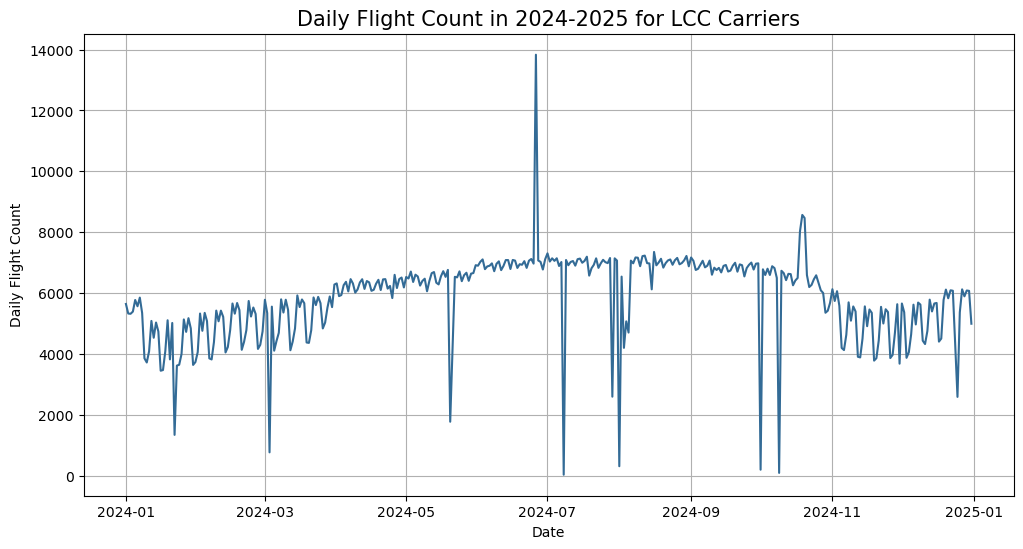

In [5]:
# count the number of flights per day
daily_flights = lcc_flights['dof'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_flights.index, daily_flights.values, linestyle='-', color='#336b96')
plt.xlabel('Date')
plt.ylabel('Daily Flight Count')
plt.title('Daily Flight Count in 2024-2025 for LCC Carriers', fontsize=15)
plt.grid(True)
plt.show()

### Data 2: Airport Data


In [6]:
airport_data = pd.read_csv('flightlist/airport1.csv') 
airport_data.head()

,id,Airport Name,City,Country,IATA,ICAO,Latitude,Longitude,Elevation
0,299,Antwerp International Airport (Deurne),Antwerp,Belgium,ANR,EBAW,51.189400,4.46028,39
1,302,Brussels Airport,Brussels,Belgium,BRU,EBBR,50.901402,4.48444,184
2,304,Brussels South Charleroi Airport,Charleroi,Belgium,CRL,EBCI,50.459202,4.45382,614
3,308,Wevelgem Airport,Kortrijk-vevelgem,Belgium,KJK,EBKT,50.817200,3.20472,64
4,309,Liège Airport,Liege,Belgium,LGG,EBLG,50.637402,5.44322,659



|**Variable**|**Description**|**Data Type**|**Unit**|
|------------|---------------|-------------|--------|
|`Airport Name`|Official name of the airport|String|-|
|`City`|City where the airport is located|String|-|
|`Country`|Country where the airport is located|String|-|
|`IATA`|IATA code of the airport|String|-|
|`ICAO`|ICAO code of the airport|String|-|
|`Latitude`|Geographical latitude of the airport|Float|Degrees (°)|
|`Longitude`|Geographical longitude of the airport|Float|Degrees (°)|
|`Elevation`|Elevation of the airport above sea level|Integer|Meters (m)|
|`Zone`|Time zone offset from UTC|Float|Hours (h)|
|`control`|Control zone of the airport|String|-|

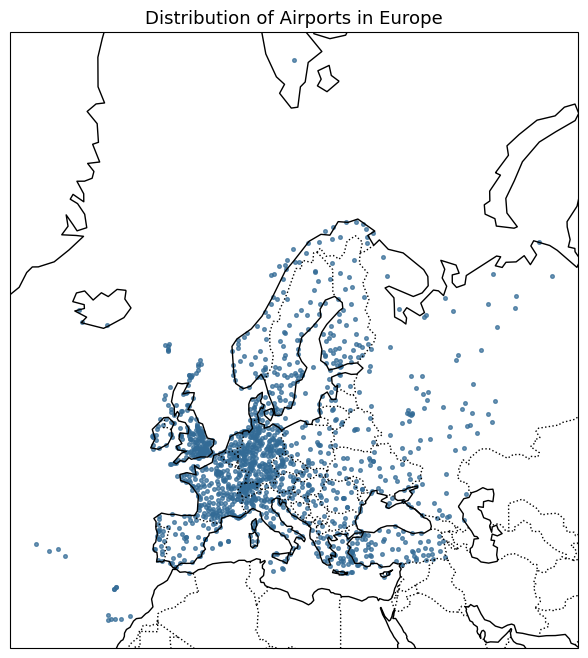

In [7]:
# plot the distribution of airports
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.Mercator()})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# plot the airports
sc = ax.scatter(
    airport_data['Longitude'],
    airport_data['Latitude'],
    c='#336b96',
    alpha=0.7,
    s=7,
    transform=ccrs.PlateCarree()  
)
ax.set_title('Distribution of Airports in Europe', fontsize=13)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

### Data 3: Passenger Flow



In [8]:
passengerEU = pd.read_csv('flightlist/passengerflowEU.csv') 
passengerUK = pd.read_csv('flightlist/passengerflowUK.csv') 
passenger = pd.concat([passengerEU, passengerUK])
passenger = passenger.sort_values(by='2024', ascending=False)
passenger.head()

,City,Airport,ICAO,2024
0,Istanbul,International,LTFM,79988272
41,London,Heathrow,EGLL,79180434
1,Paris,Charles De Gaulle,LFPG,70290260
2,Amsterdam,Schiphol,EHAM,66828453
3,Madrid,Barajas,LEMD,66196984



|**Variable**|**Description**|**Data Type**|**Unit**|
|------------|---------------|-------------|--------|
|`City`|The city where the airport is located|String|-|
|`Airport`|The name of the airport|String|-|
|`ICAO`|The ICAO code of the airport|String|-|
|`2023`|Total number of passengers in 2023|int64|Passenger Count|



C:\Users\abc96\AppData\Local\Temp\ipykernel_10108\503444129.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


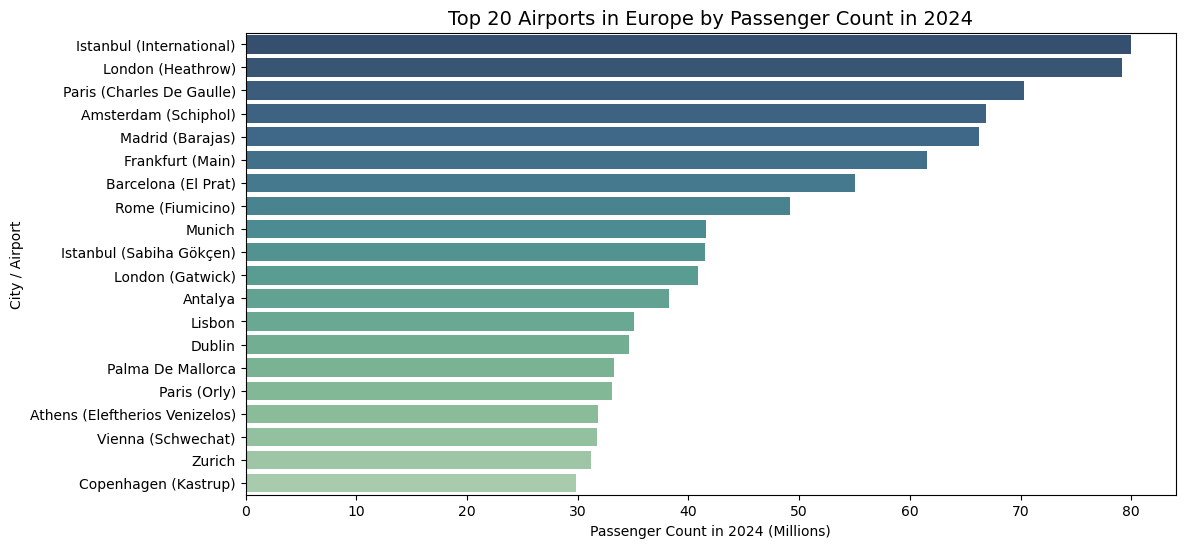

In [9]:
# top 20 airports by passenger count in 2023
top_passenger_airports = passenger.nlargest(20, '2024')

# add a column to display the city and airport name
top_passenger_airports['city_display'] = top_passenger_airports.apply(
    lambda row: row['City'] if row['City'] == row['Airport'] else f"{row['City']} ({row['Airport']})", axis=1
)

plt.figure(figsize=(12, 6))
sns.barplot(
    y='city_display',
    x=top_passenger_airports['2024'] / 1_000_000,
    data=top_passenger_airports,
    palette=get_color_palette(20),
    errorbar=None
)
plt.xlabel('Passenger Count in 2024 (Millions)')
plt.ylabel('City / Airport')
plt.title('Top 20 Airports in Europe by Passenger Count in 2024', fontsize=14)
plt.show()


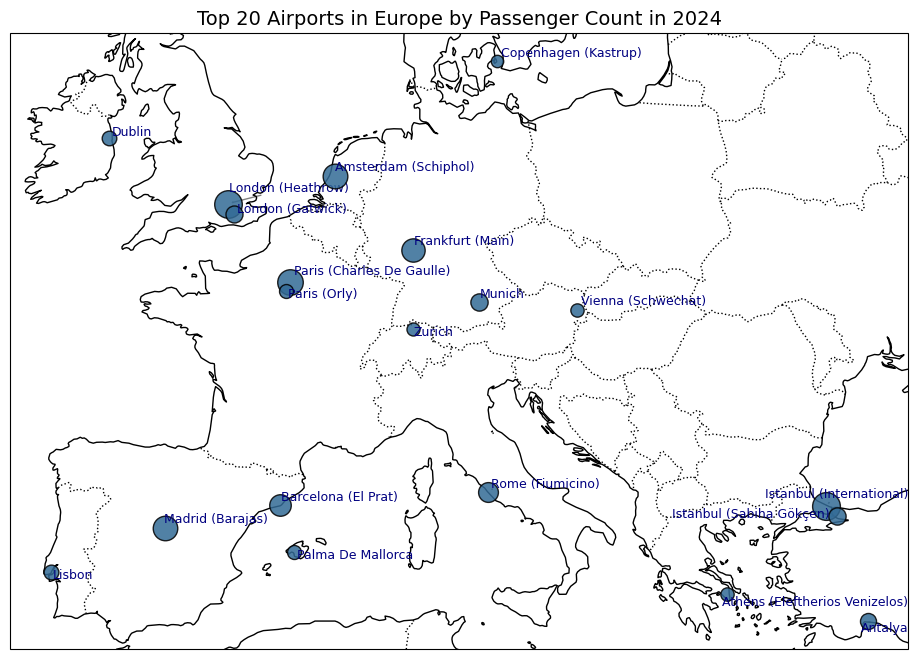

In [10]:
# Map the top 20 airports by passenger count in 2024

# Merge to get lat/lon for top airports
top_airports_map = top_passenger_airports.merge(
    airport_data[['ICAO', 'Latitude', 'Longitude']], on='ICAO', how='left'
)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.Mercator() })
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title('Top 20 Airports in Europe by Passenger Count in 2024', fontsize=14)

# Normalize passenger count for marker size
size_norm = Normalize(vmin=top_airports_map['2024'].min(), vmax=top_airports_map['2024'].max())
min_size, max_size = 80, 400

texts = []  
for _, row in top_airports_map.iterrows():
    ax.scatter(
        row['Longitude'], row['Latitude'],
        s=min_size + (max_size - min_size) * size_norm(row['2024']),
        color='#336b96', edgecolor='k', alpha=0.85, zorder=3,
        transform=ccrs.PlateCarree()  
    )
    texts.append(
        ax.text(
            row['Longitude'], row['Latitude'],
            row['city_display'], fontsize=9, color='navy',
            transform=ccrs.PlateCarree()
        )
    )

# Adjust text labels to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

In [11]:
# top_passenger_airports = passenger.nlargest(20, '2024').copy()
# top_passenger_airports['city_display'] = top_passenger_airports.apply(
#     lambda row: row['City'] if row['City'] == row['Airport'] else f"{row['City']} ({row['Airport']})", axis=1
# )

# top_airports_map = top_passenger_airports.merge(
#     airport_data[['ICAO', 'Latitude', 'Longitude']], on='ICAO', how='left'
# )

# fig = plt.figure(figsize=(14, 6))
# gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

# ax_map = fig.add_subplot(gs[0], projection=ccrs.Mercator())
# ax_map.add_feature(cfeature.LAND, facecolor='gainsboro')  
# ax_map.add_feature(cfeature.COASTLINE)
# ax_map.add_feature(cfeature.BORDERS, linestyle=":")
# ax_map.set_title('Top 20 Airports in Europe by Passenger Count in 2024')

# sample_airports = set(flights_samples['adep']).union(set(flights_samples['ades']))
# sample_airports_df = airport_data[airport_data['ICAO'].isin(sample_airports)]
# ax_map.scatter(
#     sample_airports_df['Longitude'],
#     sample_airports_df['Latitude'],
#     s=18, color='gray', alpha=0.6, zorder=1,
#     transform=ccrs.PlateCarree(),
#     label='Sample Airports'
# )

# size_norm = Normalize(vmin=top_airports_map['2024'].min(), vmax=top_airports_map['2024'].max())
# min_size, max_size = 80, 400
# texts = []
# for _, row in top_airports_map.iterrows():
#     ax_map.scatter(
#         row['Longitude'], row['Latitude'],
#         s=min_size + (max_size - min_size) * size_norm(row['2024']),
#         color='#5DADE2', edgecolor='k', alpha=0.85, zorder=3,
#         transform=ccrs.PlateCarree()
#     )
#     texts.append(
#         ax_map.text(
#             row['Longitude'], row['Latitude'],
#             row['city_display'], fontsize=9, color='navy',
#             transform=ccrs.PlateCarree()
#         )
#     )
# adjust_text(texts, ax=ax_map, arrowprops=dict(arrowstyle='->', color='gray'))

# ax_bar = fig.add_subplot(gs[1])
# top_passenger_airports_sorted = top_passenger_airports.sort_values(by='2024', ascending=True)
# bars = ax_bar.barh(
#     y=top_passenger_airports_sorted['city_display'],
#     width=top_passenger_airports_sorted['2024'] / 1_000_000,  # 
#     color=sns.color_palette("Blues", len(top_passenger_airports_sorted)),
#     edgecolor='k', alpha=0.85
# )
# ax_bar.set_xlabel('Passenger Count in 2024 (Millions)')
# ax_bar.set_title('Top 20 Airports by Passenger Count')
# ax_bar.grid(axis='x', linestyle='--', alpha=0.5)

# plt.tight_layout()
# plt.show()


### Data 4: Weather Data

|**Label**|**Variable**|**Units**|
|---------|------------|---------|
|`cld`|cloud cover|percentage (%)|
|`dtr`|diurnal temperature range|degrees Celsius|
|`frs`|frost day frequency|days|
|`pet`|potential evapotranspiration|millimetres per day|
|`pre`|precipitation|millimetres per mon1th|
|`rhm`|relative humidity|percentage (%)|
|`ssh`|sunshine duration|hours|
|`stn`|number of stations contributing to each interpolation|count 0-8|
|`tmp`|monthly average daily mean temperature|degrees Celsius|
|`tmn`|monthly average daily minimum temperature|degrees Celsius|
|`tmx`|monthly average daily maximum temperature|degrees Celsius|
|`vap`|vapour pressure|hectopascals (hPa)|
|`wet`|wet day frequency|days|
|`wnd`|wind speed|metres per second (m/s)|



In [12]:
# load the precipitation and temperature data
temperature_file = "flightlist/cru_ts4.09.2021.2024.tmp.dat.nc.gz"
precipitation_file = "flightlist/cru_ts4.09.2021.2024.pre.dat.nc.gz"
precipitation_data = xr.open_dataset(precipitation_file)
temperature_data = xr.open_dataset(temperature_file)

In [17]:
#  Define a function to extract precipitation and temperature for a given latitude and longitude

def get_precip_temp(lat, lon, precip_data, temp_data):
    #  Find the nearest latitude and longitude in the dataset
    nearest_lat = precip_data['lat'].sel(lat=lat, method="nearest").values
    nearest_lon = precip_data['lon'].sel(lon=lon, method="nearest").values
    #  Extract the precipitation and temperature data for the nearest lat/lon
    precip = precip_data['pre'].sel(lat=nearest_lat, lon=nearest_lon).mean(dim='time').item()
    temp = temp_data['tmp'].sel(lat=nearest_lat, lon=nearest_lon).mean(dim='time').item()
    return precip, temp

#  Iterate over the airport data to get precipitation and temperature for each airport
weather_results = []
for _, row in airport_data.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    precip, temp = get_precip_temp(lat, lon, precipitation_data, temperature_data)
    weather_results.append({'ICAO': row['ICAO'], 'Precipitation': precip, 'Temperature': temp})

weather_df = pd.DataFrame(weather_results)
airport_data = airport_data.merge(weather_df, on='ICAO', how='left')
airport_data.head()

,id,Airport Name,City,Country,IATA,ICAO,Latitude,Longitude,Elevation,Precipitation,Temperature
0,299,Antwerp International Airport (Deurne),Antwerp,Belgium,ANR,EBAW,51.189400,4.46028,39,75.047935,12.045833
1,302,Brussels Airport,Brussels,Belgium,BRU,EBBR,50.901402,4.48444,184,78.937508,11.879165
2,304,Brussels South Charleroi Airport,Charleroi,Belgium,CRL,EBCI,50.459202,4.45382,614,87.229149,11.364582
3,308,Wevelgem Airport,Kortrijk-vevelgem,Belgium,KJK,EBKT,50.817200,3.20472,64,70.943748,12.002086
4,309,Liège Airport,Liege,Belgium,LGG,EBLG,50.637402,5.44322,659,77.883339,11.710416


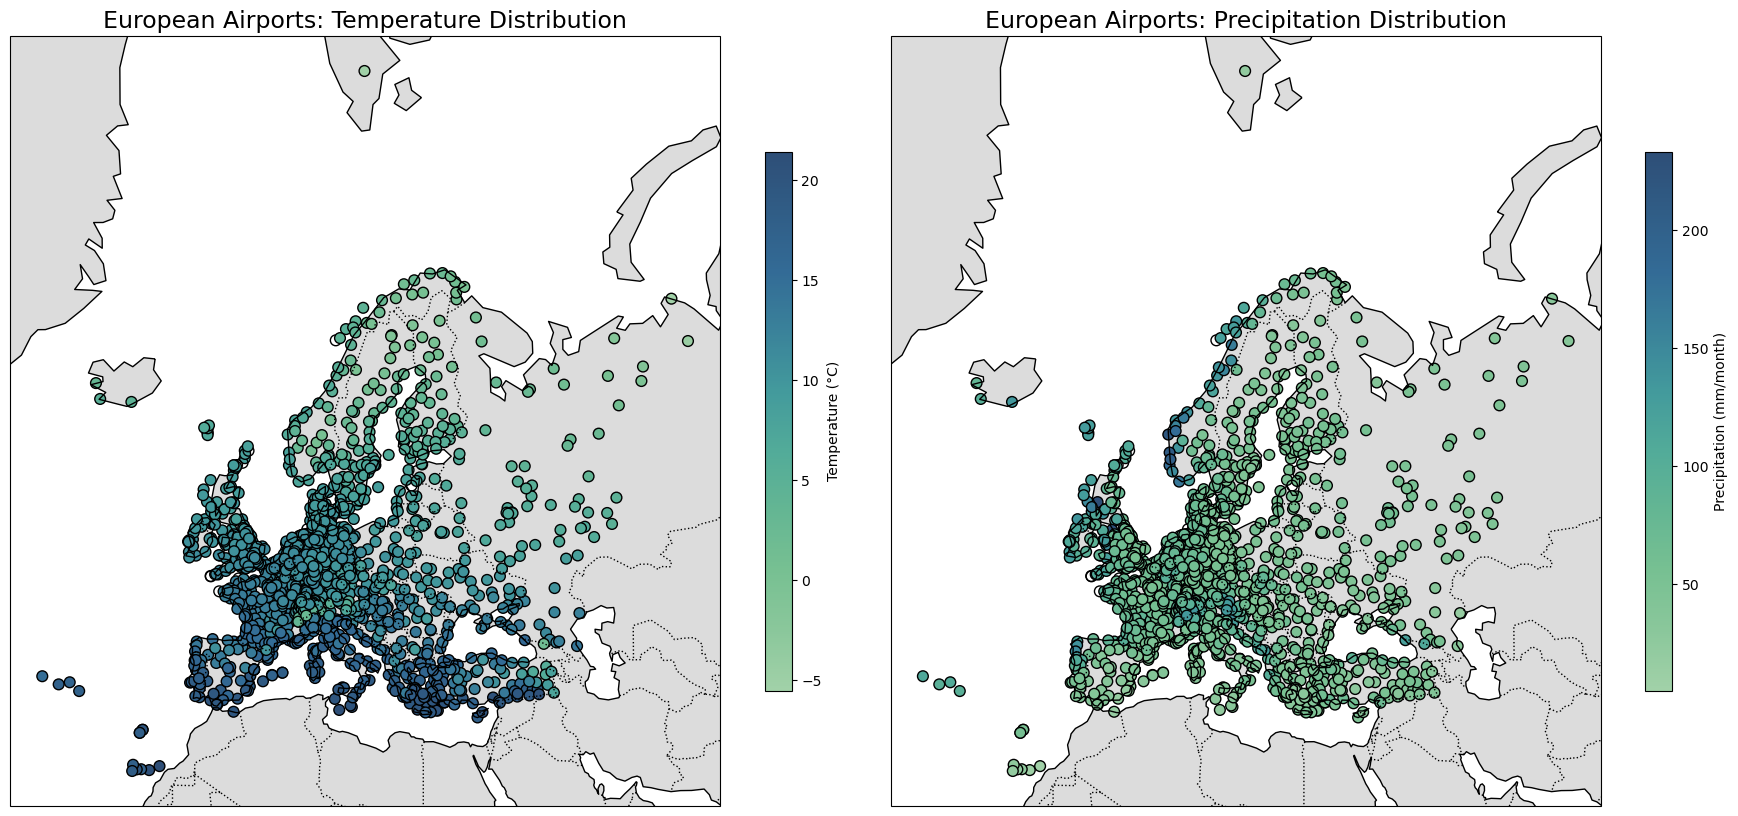

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": ccrs.Mercator()})

# 气温分布
ax1 = axes[0]
ax1.add_feature(cfeature.LAND, facecolor='gainsboro')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=":")
sc1 = ax1.scatter(
    airport_data['Longitude'],
    airport_data['Latitude'],
    c=airport_data['Temperature'],
    cmap=get_cmap(),
    s=60,
    edgecolor='k',
    transform=ccrs.PlateCarree()
)
cbar1 = plt.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.7, label='Temperature (°C)')
ax1.set_title('European Airports: Temperature Distribution', fontsize=17)

# 降水分布
ax2 = axes[1]
ax2.add_feature(cfeature.LAND, facecolor='gainsboro')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=":")
sc2 = ax2.scatter(
    airport_data['Longitude'],
    airport_data['Latitude'],
    c=airport_data['Precipitation'],
    cmap=get_cmap(),
    s=60,
    edgecolor='k',
    transform=ccrs.PlateCarree()
)
cbar2 = plt.colorbar(sc2, ax=ax2, orientation='vertical', shrink=0.7, label='Precipitation (mm/month)')
ax2.set_title('European Airports: Precipitation Distribution', fontsize=17)

plt.tight_layout()
plt.show()

### Data 5: GDP


In [21]:
GDP = pd.read_excel("flightlist/gdp.xlsx")
GDP.head()

,Country,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4,Y2023,2024-Q1,2024-Q2,2024-Q3,2024-Q4,Y2024
0,Albania,3242.1,2919.6,3405.6,3367.2,3379.4,13071.8,3035.2,3542.6,3509.8,3502.2,13589.8
1,Austria,90391.5,86617.8,86311.4,84735.3,88047.0,345711.5,84974.9,85081.7,83997.6,87600.3,341654.5
2,Belgium,114899.0,106922.0,112021.5,105041.5,115475.1,439460.1,107742.4,113141.1,106283.5,116770.7,443937.7
3,Bosnia and Herzegovina,4447.6,4201.9,4406.7,4555.3,4512.0,17675.9,4305.0,4508.8,4674.0,4626.5,18114.3
4,Bulgaria,14219.6,10556.6,11844.6,14053.3,14480.6,50935.1,10752.8,12113.1,14421.7,15079.1,52366.7


## Data Wrangling


### Data Processing: Airport Data


In [22]:
# airport_data = airport_data[airport_data["control"] == "Europe"].drop(columns=["IATA", "Zone", "control"])
airport_data = airport_data.merge(
    passenger[["2024", "ICAO"]], on="ICAO", how="left"
).dropna(subset=["2024"])
airport_data = airport_data.rename(columns={"2024": "passenger"})
airport_data.head()

,id,Airport Name,City,Country,IATA,ICAO,Latitude,Longitude,Elevation,Precipitation,Temperature,passenger
0,299,Antwerp International Airport (Deurne),Antwerp,Belgium,ANR,EBAW,51.189400,4.46028,39,75.047935,12.045833,202411.0
1,302,Brussels Airport,Brussels,Belgium,BRU,EBBR,50.901402,4.48444,184,78.937508,11.879165,23610856.0
2,304,Brussels South Charleroi Airport,Charleroi,Belgium,CRL,EBCI,50.459202,4.45382,614,87.229149,11.364582,10504554.0
4,309,Liège Airport,Liege,Belgium,LGG,EBLG,50.637402,5.44322,659,77.883339,11.710416,91253.0
5,310,Ostend-Bruges International Airport,Ostend,Belgium,OST,EBOS,51.198898,2.86222,13,66.412498,11.806251,251848.0


In [23]:
airport_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 0 to 1430
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             533 non-null    int64  
 1   Airport Name   533 non-null    object 
 2   City           533 non-null    object 
 3   Country        533 non-null    object 
 4   IATA           533 non-null    object 
 5   ICAO           533 non-null    object 
 6   Latitude       533 non-null    float64
 7   Longitude      533 non-null    float64
 8   Elevation      533 non-null    int64  
 9   Precipitation  531 non-null    float64
 10  Temperature    531 non-null    float64
 11  passenger      533 non-null    float64
dtypes: float64(5), int64(2), object(5)
memory usage: 54.1+ KB


### Data Processing: Flight Data



In [24]:
# clean the flights data
flights_merged = lcc_flights.drop(
    columns=[
        "adep_p",
        "ades_p",
        "id",
        "icao24",
        "model",
        "registration",
        "version",
        "unix_time",
        "icao_operator",
    ]
)
flights_merged = flights_merged.dropna(subset=["adep", "ades", "icao_aircraft_class"])

# merge the airport data with the flights data
flights_merged = flights_merged.merge(
    airport_data[["ICAO", "Latitude", "Longitude", "Country", "City"]],
    left_on="adep",
    right_on="ICAO",
    how="left",
)
flights_merged = flights_merged.rename(
    columns={
        "Latitude": "dep_lat",
        "Longitude": "dep_lon",
        "Country": "dep_country",
        "City": "dep_city",
    }
).drop(columns=["ICAO"])
flights_merged = flights_merged.merge(
    airport_data[["ICAO", "Latitude", "Longitude", "Country", "City"]],
    left_on="ades",
    right_on="ICAO",
    how="left",
)
flights_merged = flights_merged.rename(
    columns={
        "Latitude": "des_lat",
        "Longitude": "des_lon",
        "Country": "des_country",
        "City": "des_city",
    }
).drop(columns=["ICAO"])

# select the flights that are between two airports in the airport data
flights_cleaned = flights_merged[
    (flights_merged["adep"].isin(airport_data["ICAO"]))
    & (flights_merged["ades"].isin(airport_data["ICAO"]))
]

# get the unique airports(ICAO) involved in the selected flights
involved_airports = pd.unique(flights_cleaned[["adep", "ades"]].values.ravel("K"))

In [25]:
flights_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710263 entries, 1 to 811764
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   flt_id               710263 non-null  object        
 1   dof                  710263 non-null  datetime64[us]
 2   adep                 710263 non-null  object        
 3   ades                 710263 non-null  object        
 4   typecode             710263 non-null  object        
 5   icao_aircraft_class  710263 non-null  object        
 6   first_seen           710263 non-null  datetime64[us]
 7   last_seen            710263 non-null  datetime64[us]
 8   dep_lat              710263 non-null  float64       
 9   dep_lon              710263 non-null  float64       
 10  dep_country          710263 non-null  object        
 11  dep_city             710263 non-null  object        
 12  des_lat              710263 non-null  float64       
 13  des_lon            

In [26]:
flights_cleaned.head()

,flt_id,dof,adep,ades,typecode,icao_aircraft_class,first_seen,last_seen,dep_lat,dep_lon,dep_country,dep_city,des_lat,des_lon,des_country,des_city
1,PGT12NB,2024-01-01,EDDN,LTFJ,A320,L2J,2024-01-01 00:32:15,2024-01-01 02:59:55,49.498699,11.078056,Germany,Nuernberg,40.898602,29.30920,Turkey,Istanbul
2,MABEU,2024-01-01,EGSS,LOWW,LJ45,L2J,2024-01-01 02:23:45,2024-01-01 04:02:55,51.884998,0.235000,United Kingdom,London,48.110298,16.56970,Austria,Vienna
3,RYR5HH,2024-01-01,LGAV,EBCI,B738,L2J,2024-01-01 03:53:15,2024-01-01 06:59:55,37.936401,23.944500,Greece,Athens,50.459202,4.45382,Belgium,Charleroi
4,WMT9749,2024-01-01,LROP,EDLW,A21N,L2J,2024-01-01 03:56:35,2024-01-01 06:19:10,44.571111,26.085000,Romania,Bucharest,51.518299,7.61224,Germany,Dortmund
5,WMT614,2024-01-01,LROP,LIPZ,A321,L2J,2024-01-01 03:59:20,2024-01-01 06:29:20,44.571111,26.085000,Romania,Bucharest,45.505299,12.35190,Italy,Venice


In [27]:
# 'BIKF' in flights_cleaned['ades'].values
# AAA= flights_cleaned[flights_cleaned['ades'] == 'ENGM']
# AAA.head()

### Data Integration



In [28]:
# select the airports involved in the selected flights
selected_airports = airport_data[airport_data['ICAO'].isin(involved_airports)]

# define a function to get the precipitation and temperature data for a given latitude and longitude
def get_precip_temp(lat, lon, precip_data, temp_data):
    # find the nearest grid point
    nearest_lat = precip_data['lat'].sel(lat=lat, method="nearest").values
    nearest_lon = precip_data['lon'].sel(lon=lon, method="nearest").values

    # extract the precipitation and temperature data
    precip = precip_data['pre'].sel(lat=nearest_lat, lon=nearest_lon).mean(dim='time').values
    temp = temp_data['tmp'].sel(lat=nearest_lat, lon=nearest_lon).mean(dim='time').values

    # convert to float if the data is a list or numpy array
    precip = float(precip) if isinstance(precip, (list, np.ndarray)) else precip
    temp = float(temp) if isinstance(temp, (list, np.ndarray)) else temp

    return precip, temp

# get the precipitation and temperature data for the selected airports
results = []
for _, row in selected_airports.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    precip, temp = get_precip_temp(lat, lon, precipitation_data, temperature_data)
    results.append({
        'ICAO': row['ICAO'],
        'Airport Name': row['Airport Name'],
        'City': row['City'],
        'Country': row['Country'],
        'Precipitation': precip,
        'Temperature': temp
    })

# create a DataFrame from the results
airport_weather = pd.DataFrame(results)
airport_weather.head()

,ICAO,Airport Name,City,Country,Precipitation,Temperature
0,EBAW,Antwerp International Airport (Deurne),Antwerp,Belgium,75.047935,12.045833
1,EBBR,Brussels Airport,Brussels,Belgium,78.937508,11.879165
2,EBCI,Brussels South Charleroi Airport,Charleroi,Belgium,87.229149,11.364582
3,EBLG,Liège Airport,Liege,Belgium,77.883339,11.710416
4,EBOS,Ostend-Bruges International Airport,Ostend,Belgium,66.412498,11.806251


## Data Analysis & Results<br>


In [ ]:
# 'LTAB' in flights_cleaned['adep'].values

In [ ]:
# flights_samples = flights_cleaned.sample(frac=0.001, random_state=42)
# flights_samples["route"] = flights_samples.apply(
#     lambda row: f"{row['dep_city']} <-> {row['des_city']}", axis=1
# )

In [29]:
#  Define a function to extract precipitation and temperature for a given latitude and longitude
flights_cleaned['route_city'] = flights_cleaned.apply(
    lambda row: ' <-> '.join(sorted([row['dep_city'], row['des_city']])), axis=1
)

route_coords = flights_cleaned.groupby(['route_city', 'dep_lon', 'dep_lat', 'des_lon', 'des_lat']).size().reset_index(name='count')

all_routes = route_coords.sort_values(by='count', ascending=False)

print(all_routes.head())


                           route_city   dep_lon    dep_lat   des_lon  \
1074  Barcelona <-> Palma de Mallorca  2.078460  41.297100  2.738810   
1029             Barcelona <-> London  2.078460  41.297100 -0.190278   
1025             Barcelona <-> London -0.190278  51.148102  2.078460   
1075  Barcelona <-> Palma de Mallorca  2.738810  39.551701  2.078460   
4110                Dublin <-> London -0.190278  51.148102 -6.270070   

        des_lat  count  
1074  39.551701   3028  
1029  51.148102   2938  
1025  41.297100   2938  
1075  41.297100   2638  
4110  53.421299   2440  


C:\Users\abc96\AppData\Local\Temp\ipykernel_10108\3485928533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_cleaned['route_city'] = flights_cleaned.apply(


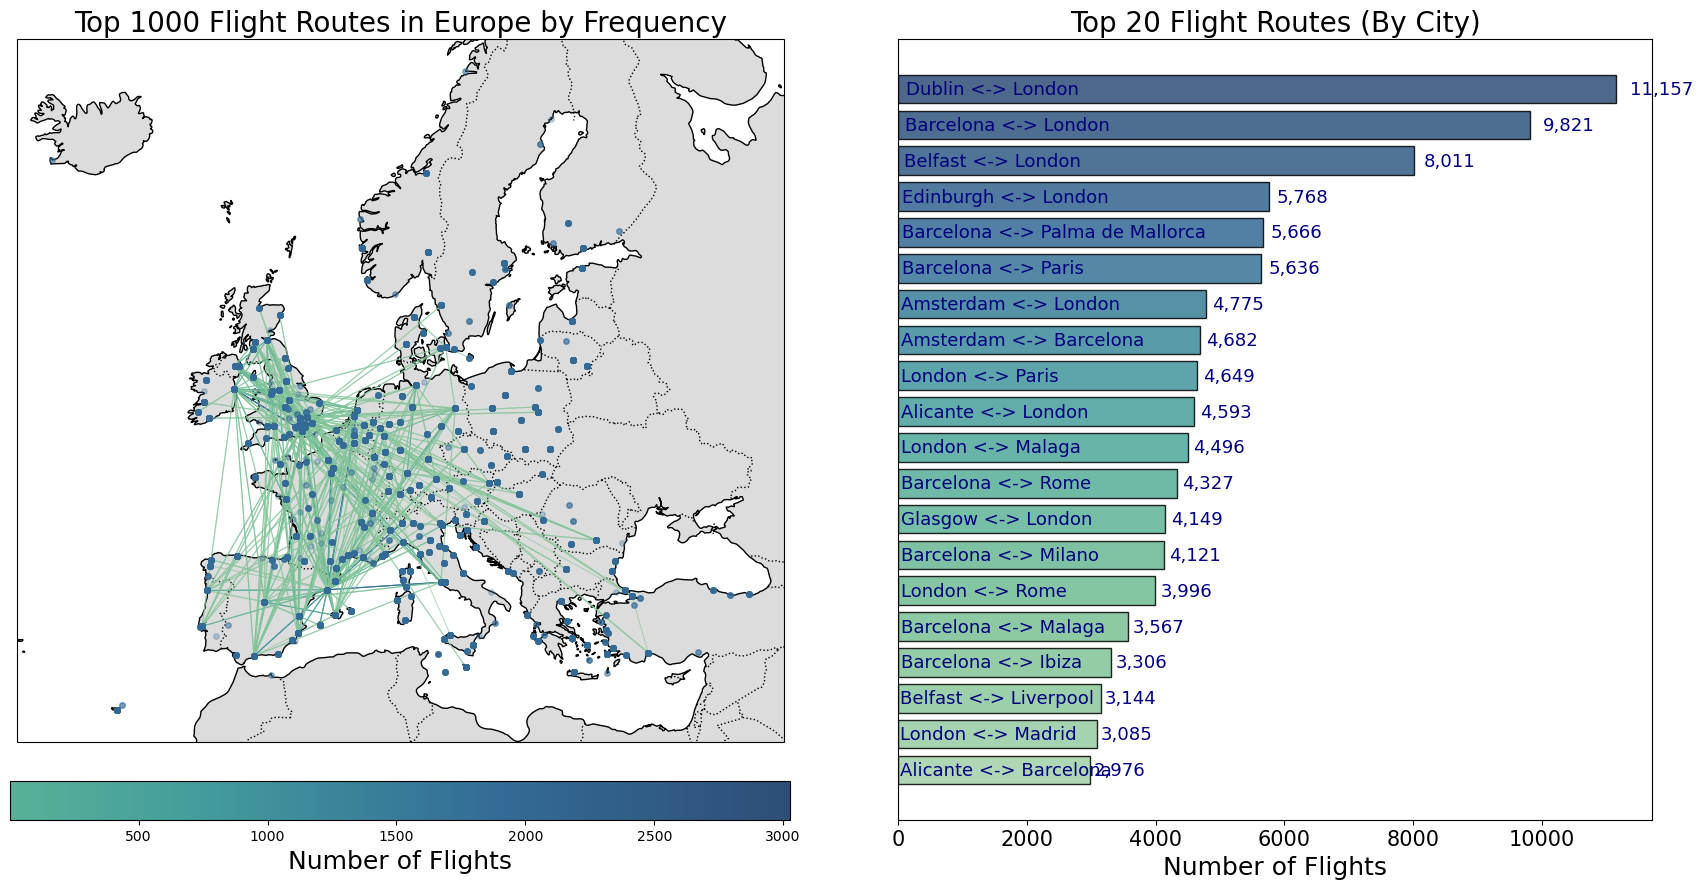

In [30]:
fig = plt.figure(figsize=(18, 9))
gs = plt.GridSpec(1, 2, width_ratios=[1.5, 1.2])

# map
ax_map = fig.add_subplot(gs[0], projection=ccrs.Mercator())
ax_map.add_feature(cfeature.LAND, facecolor='gainsboro')  
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS, linestyle=":")
ax_map.set_title("Top 1000 Flight Routes in Europe by Frequency", fontsize=20)
ax_map.tick_params(labelsize=15)

# normalize the count for colormap
full_cmap = get_cmap()
new_cmap = LinearSegmentedColormap.from_list('cut_blues', full_cmap(np.linspace(0.4, 1)), N=256)
norm = Normalize(vmin=all_routes['count'].min(), vmax=all_routes['count'].max())
sm = ScalarMappable(norm=norm, cmap=new_cmap)

top_N = 500
all_routes_top = all_routes.nlargest(top_N, 'count')

for _, row in all_routes_top.iterrows():
    # line_width = 0.5 + (row['count'] / all_routes_top['count'].max()) * 4  
    ax_map.plot(
        [row['dep_lon'], row['des_lon']], [row['dep_lat'], row['des_lat']],
        color=full_cmap(norm(row['count'])),
        linewidth=0.8,
        alpha = min(1, 0.5 + (row['count'] / all_routes_top['count'].max()) / 1.5),
        transform=ccrs.PlateCarree(),
        zorder=2
    )
ax_map.scatter(
    all_routes['dep_lon'], all_routes['dep_lat'],
    color="#336b96", s=15, transform=ccrs.PlateCarree(), alpha=0.29, zorder=3
)
ax_map.scatter(
    all_routes['des_lon'], all_routes['des_lat'],
    color="#336b96", s=15, transform=ccrs.PlateCarree(), alpha=0.29, zorder=3
)

cbar = plt.colorbar(sm, ax=ax_map, orientation="horizontal", pad=0.05, fraction=0.05)
cbar.set_label("Number of Flights", fontsize=18)

# bar chart
route_counts_city = flights_cleaned['route_city'].value_counts().reset_index()
route_counts_city.columns = ['route_city', 'count']
top20 = route_counts_city.sort_values(by='count', ascending=False).head(20)
ax_bar = fig.add_subplot(gs[1])
y_positions = range(len(top20))
bars = ax_bar.barh(y=y_positions, width=top20['count'], color=get_color_palette(20), edgecolor='k', alpha=0.85)
ax_bar.set_yticks([])
ax_bar.set_ylabel('', fontsize=18)
ax_bar.tick_params(axis='x', labelsize=15)
ax_bar.tick_params(axis='y', labelsize=15)
ax_bar.set_xlabel("Number of Flights", fontsize=18)
ax_bar.set_title("Top 20 Flight Routes (By City)", fontsize=20)


min_width = top20['count'].max() * 0.05
for bar, label, count in zip(bars, top20['route_city'], top20['count']):
    width = bar.get_width()
    label_length = len(label)
    text_x_label = width * 0.01 if width > min_width else min_width * 0.01
    text_x_count = max(width + (width * 0.02), label_length * 10)  
    
    ax_bar.text(text_x_label, bar.get_y() + bar.get_height() / 2, label, 
                va='center', ha='left', color='navy', fontsize=13)
    ax_bar.text(text_x_count, bar.get_y() + bar.get_height() / 2, f"{int(count):,}",
                va='center', ha='left', color='navy', fontsize=13)

ax_bar.invert_yaxis()
plt.tight_layout()
plt.show()

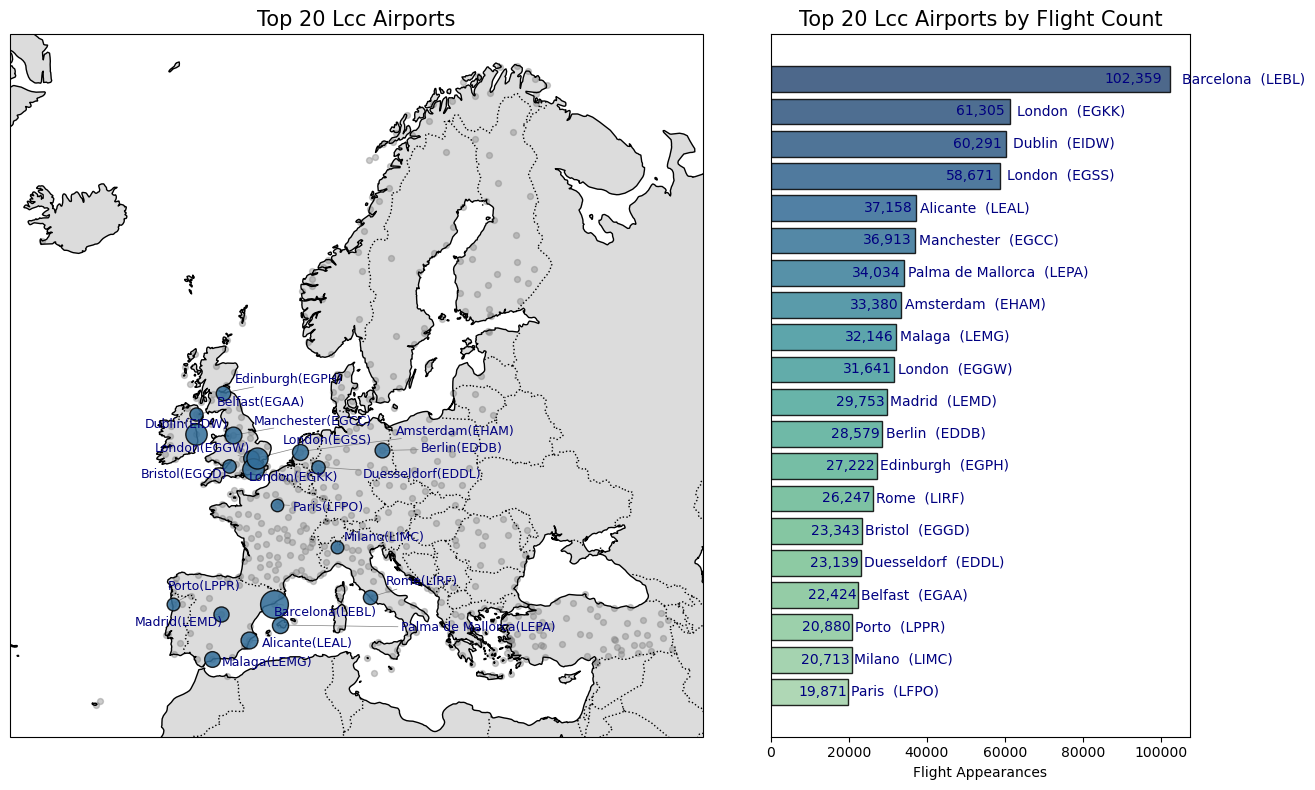

In [32]:
# Count total appearances of each airport as departure or arrival
adep_counts = flights_cleaned['adep'].value_counts()
ades_counts = flights_cleaned['ades'].value_counts()
total_counts = adep_counts.add(ades_counts, fill_value=0)

# Get top 20 airports by total appearances
top20_icao = total_counts.sort_values(ascending=False).head(20).index.tolist()

# Get geographic info for top 20 airports
top20_airports = airport_data[airport_data['ICAO'].isin(top20_icao)].copy()
top20_airports['total_count'] = top20_airports['ICAO'].map(total_counts)
# Sort top 20 airports by total_count descending for bar plot
top20_airports_sorted = top20_airports.sort_values('total_count', ascending=False)

# Create figure with GridSpec for 7:3 split
fig = plt.figure(figsize=(14, 8))
gs = plt.GridSpec(1, 2, width_ratios=[2, 1])

# Left: Map
ax_map = fig.add_subplot(gs[0], projection=ccrs.Mercator())
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.LAND, facecolor='gainsboro')  
ax_map.add_feature(cfeature.BORDERS, linestyle=":")
ax_map.set_title('Top 20 Lcc Airports', fontsize=15)

# Plot all airports as small light gray dots
ax_map.scatter(
    airport_data['Longitude'],
    airport_data['Latitude'],
    s=18, color='gray', alpha=0.4, zorder=1,
    transform=ccrs.PlateCarree(),
    label='All Airports'
)

# Normalize marker size
size_norm = Normalize(vmin=top20_airports['total_count'].min(), vmax=top20_airports['total_count'].max())
min_size, max_size = 80, 400

texts = []
for _, row in top20_airports.iterrows():
    ax_map.scatter(
        row['Longitude'], row['Latitude'],
        s=min_size + (max_size - min_size) * size_norm(row['total_count']),
        color='#336e99', edgecolor='k', alpha=0.85, zorder=2,
        transform=ccrs.PlateCarree()
    )
    texts.append(
        ax_map.text(
            row['Longitude'], row['Latitude'],
            f"{row['City']}({row['ICAO']})", fontsize=9, color='navy',
            transform=ccrs.PlateCarree()
        )
    )
adjust_text(texts, ax=ax_map, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
# Right: Bar plot (move outside of the loop)
ax_bar = fig.add_subplot(gs[1])
y_positions = range(len(top20_airports_sorted))
# bar_colors = [sns.color_palette("Blues_r", n_colors=len(top20_airports_sorted))[i] for i in range(len(top20_airports_sorted))]

bars = ax_bar.barh(
    y=y_positions,
    width=top20_airports_sorted['total_count'],
    color=get_color_palette(20),
    edgecolor='k',
    alpha=0.85
)

# Add labels and counts manually
for bar, (index, row) in zip(bars, top20_airports_sorted.iterrows()):
    label = f"{row['City']}  ({row['ICAO']})"
    count = row['total_count']
    ax_bar.text(
        bar.get_width() + (bar.get_width() * 0.03),
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center', ha='left',
        color='navy', fontsize=10
    )
    ax_bar.text(
        bar.get_width() - (bar.get_width() * 0.02),
        bar.get_y() + bar.get_height() / 2,
        f"{int(count):,}",
        va='center', ha='right',
        color='navy', fontsize=10,
    )

# Finalize bar plot
ax_bar.set_yticks([])  # Hide y-axis labels
ax_bar.set_ylabel('')
ax_bar.set_xlabel('Flight Appearances')
ax_bar.set_title('Top 20 Lcc Airports by Flight Count', fontsize=15)
ax_bar.invert_yaxis()

plt.tight_layout()
plt.show()


### Monthly Flight Analysis




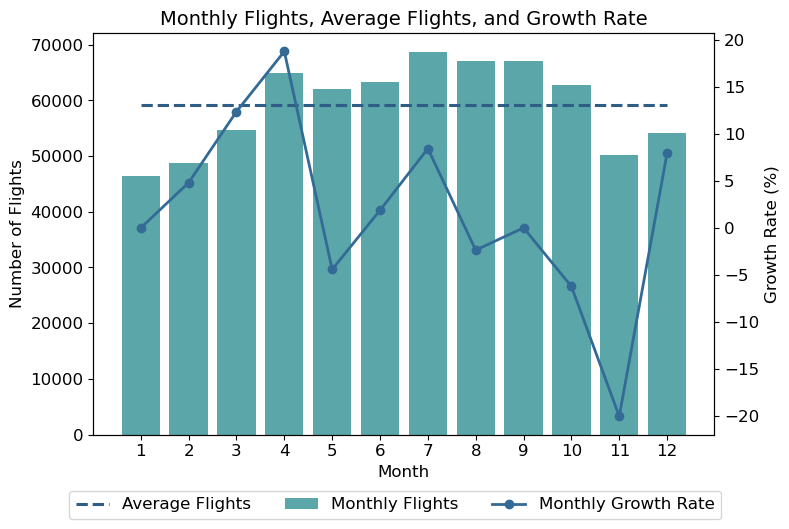

In [34]:
main_palette = get_color_palette(10, reverse=True)
bar_color    = main_palette[4]
line_color   = main_palette[1]
growth_color = main_palette[2]

flights_cleaned.loc[:, 'month'] = flights_cleaned['first_seen'].dt.month
monthly_flights = flights_cleaned['month'].value_counts().sort_index()
average_flights = monthly_flights.mean()
monthly_growth_rate = monthly_flights.pct_change().replace([np.inf, -np.inf], 0).fillna(0) * 100

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.bar(
    monthly_flights.index,
    monthly_flights.values,
    color=bar_color,
    alpha=0.88,
    label='Monthly Flights'
)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Number of Flights', fontsize=12)
ax1.tick_params(axis='y',  labelsize=12)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(range(1, 13), fontsize=12)

ax1.plot(
    monthly_flights.index,
    [average_flights] * len(monthly_flights),
    color=line_color, linestyle='--', linewidth=2.2, label='Average Flights'
)

ax2 = ax1.twinx()
ax2.plot(
    monthly_growth_rate.index,
    monthly_growth_rate.values,
    color=growth_color,
    marker='o',
    label='Monthly Growth Rate',
    linewidth=2
)
ax2.set_ylabel('Growth Rate (%)', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.025), ncol=3, fontsize=12)

plt.title('Monthly Flights, Average Flights, and Growth Rate', fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\abc96\AppData\Local\Temp\ipykernel_10108\3930423817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_cleaned['dep_hour'] = flights_cleaned['first_seen'].dt.hour
C:\Users\abc96\AppData\Local\Temp\ipykernel_10108\3930423817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_cleaned['dep_weekday'] = flights_cleaned['first_seen'].dt.weekday


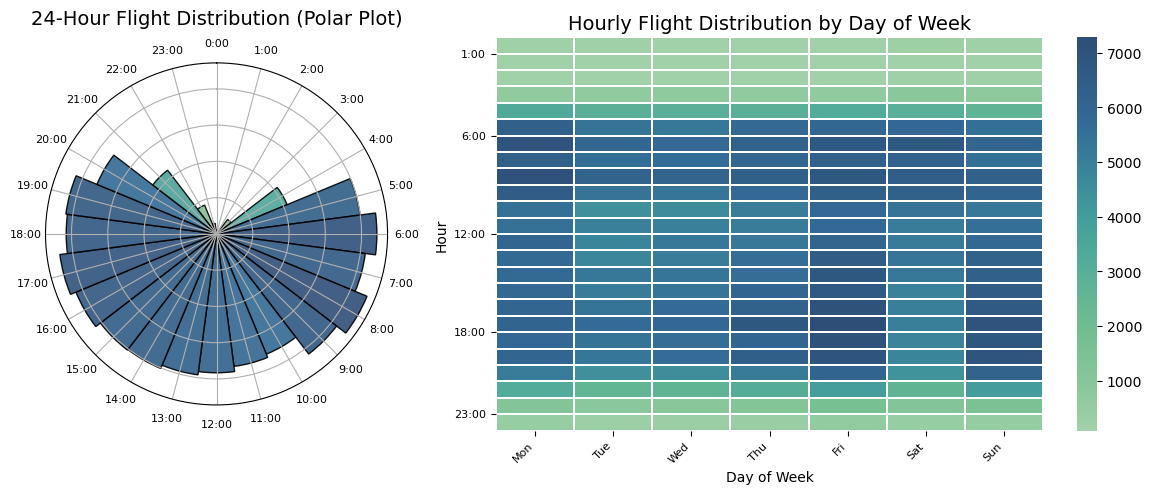

In [38]:
flights_cleaned['dep_hour'] = flights_cleaned['first_seen'].dt.hour
flights_cleaned['dep_weekday'] = flights_cleaned['first_seen'].dt.weekday
hourly_summary = flights_cleaned.groupby('dep_hour')['flt_id'].count().sort_index()
theta = 2 * np.pi * hourly_summary.index / 24
radii = hourly_summary.values

heat_data = np.zeros((7, 24))
for i in range(7):
    subset = flights_cleaned[flights_cleaned['dep_weekday'] == i]
    hourly_counts = subset.groupby('dep_hour')['flt_id'].count().reindex(range(24), fill_value=0)
    heat_data[i, :] = hourly_counts.values

fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

ax_polar = fig.add_subplot(gs[0], projection='polar')
my_cmap = get_cmap(reverse=False)  
normed_radii = radii / radii.max()
bar_colors = [my_cmap(val) for val in normed_radii]
bars = ax_polar.bar(
    theta, radii, width=2*np.pi/24, bottom=0.0,
    color=bar_colors, edgecolor='black', alpha=0.9
)

ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(-1)
ax_polar.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax_polar.set_xticklabels([f'{int(i)}:00' for i in np.arange(0, 24, 1)], fontsize=8)
ax_polar.set_yticklabels([])
ax_polar.set_title('24-Hour Flight Distribution (Polar Plot)', fontsize=14, pad=28)

ax_heat = fig.add_subplot(gs[1])
pivot_table = flights_cleaned.groupby(['dep_hour', 'dep_weekday'])['flt_id'].count().unstack(fill_value=0)
pivot_table = pivot_table.reindex(index=range(24), columns=range(7), fill_value=0)

my_cmap = get_cmap(reverse=False)
sns.heatmap(pivot_table, ax=ax_heat, cmap=my_cmap, cbar=True, linewidths=0.1, linecolor='white')

ax_heat.set_xlabel('Day of Week')
ax_heat.set_ylabel('Hour')
# Move the title above the heatmap to avoid overlapping with the plot
ax_heat.set_title('Hourly Flight Distribution by Day of Week', fontsize=14)
ax_heat.set_xticks(np.arange(7) + 0.5)
ax_heat.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=45, ha='right')
ax_heat.set_yticks([1, 6, 12, 18, 23])
ax_heat.set_yticklabels([f'{h}:00' for h in [1, 6, 12, 18, 23]])
ax_heat.tick_params(axis='x', labelsize=8)
ax_heat.tick_params(axis='y', labelsize=8)

plt.tight_layout()


### Airport Seasonality Analysis


In [39]:
# define a function to calculate gini index
def calculate_gini(flight_counts):
    
    flight_counts = np.array(flight_counts)
    sorted_counts = np.sort(flight_counts)
    
    # calculate the cumulative flights and proportion
    cumulative_flights = np.cumsum(sorted_counts)
    cumulative_proportion_x = np.arange(1, len(flight_counts) + 1) / len(flight_counts)
    cumulative_proportion_y = cumulative_flights / cumulative_flights[-1]
    
    # calculate the gini index
    gini = 1 - np.sum(
        (cumulative_proportion_x[1:] - cumulative_proportion_x[:-1]) * 
        (cumulative_proportion_y[1:] + cumulative_proportion_y[:-1])
    )
    return gini

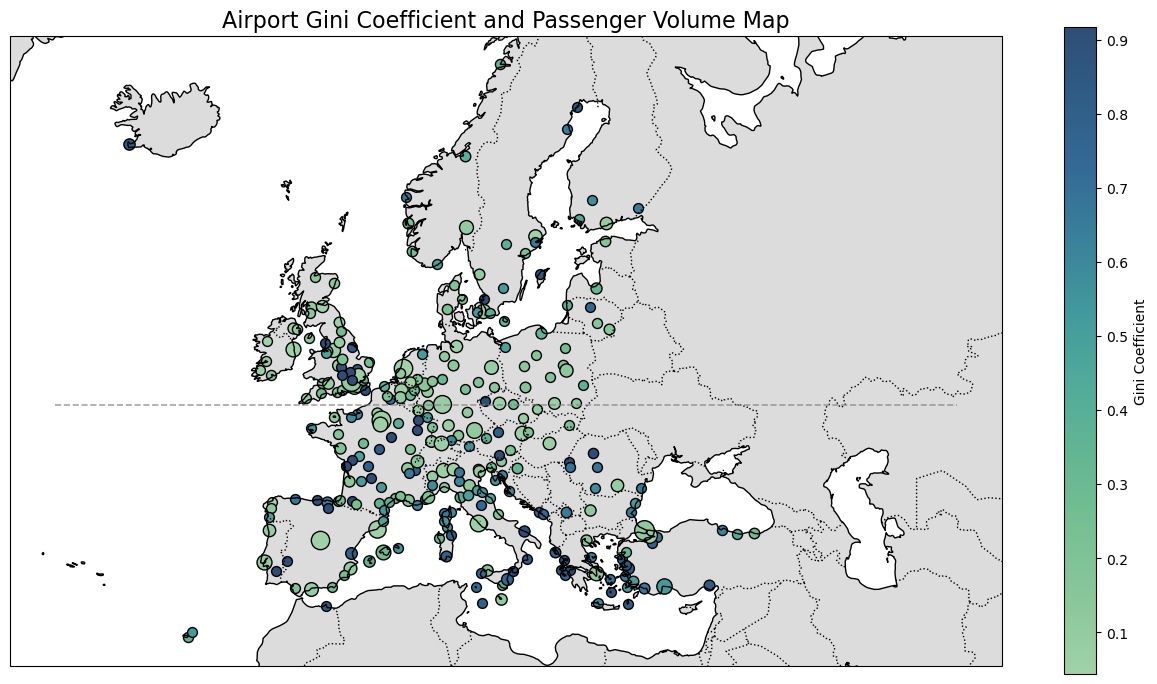

In [42]:
# extract the monthly flights for each airport
airport_monthly_flights = flights_cleaned.groupby(['ades', 'month']).size().unstack(fill_value=0)

#  calculate the gini index for each airport
airport_gini = airport_monthly_flights.apply(calculate_gini, axis=1).reset_index()
airport_gini.columns = ['ICAO', 'gini']

# merge the gini index with the passenger data
airport_gini = airport_gini.merge(airport_data[['ICAO', 'passenger','Longitude','Latitude']], on='ICAO', how='left')

cmap = get_cmap(reverse=False) 

norm = Normalize(vmin=airport_gini['gini'].min(), vmax=airport_gini['gini'].max()) 

# point size based on passenger volume
size_norm = Normalize(vmin=airport_gini['passenger'].min(), vmax=airport_gini['passenger'].max())
min_size, max_size = 50, 200  

fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={"projection": ccrs.Mercator()})
ax.add_feature(cfeature.LAND, facecolor='gainsboro')  
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# plot each airport
for _, row in airport_gini.iterrows():
    lon, lat, gini, num = row["Longitude"], row["Latitude"], row["gini"], row["passenger"]
    if pd.notna(lon) and pd.notna(lat) and pd.notna(num):  # insure the data is not missing
        ax.scatter(
            lon, lat,
            color=cmap(norm(gini)), 
            s=min_size + (max_size - min_size) * size_norm(num), 
            edgecolor="k",
            transform=ccrs.PlateCarree()
        )

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7, label="Gini Coefficient")

ax.plot(
    [-30, 60], [50, 50], 
    color='gray', linestyle='--', linewidth=1.2, alpha=0.7,
    transform=ccrs.PlateCarree(),
    label='Latitude 50°N'
)
plt.title("Airport Gini Coefficient and Passenger Volume Map", fontsize=16)
plt.show()

count top10 airport gini and change rate


In [41]:
# calculate the monthly change in flights for each airport
airport_monthly_flights = flights_cleaned.groupby(['adep', 'month']).size().unstack(fill_value=0)

# calculate the monthly change in flights
airport_monthly_change = airport_monthly_flights.diff(axis=1).fillna(0)
airport_monthly_change_rate = airport_monthly_change.div(airport_monthly_flights.shift(axis=1)).fillna(0) * 100

# top 10 airports with the largest change in flights
top_10_airports_change = airport_monthly_change.abs().sum(axis=1).nlargest(10).index

# get the data for the top 10 airports
top_10_airports_data = airport_gini[airport_gini['ICAO'].isin(top_10_airports_change)]
top_10_airports_data = top_10_airports_data.sort_values(by='gini', ascending=False).reset_index(drop=True)
top_10_airports_data['rank'] = top_10_airports_data.index + 1

# calculate the total change and change rate for the top 10 airports
top_10_airports_data['total_change'] = airport_monthly_change.loc[top_10_airports_change].abs().sum(axis=1).values
top_10_airports_data['change_rate'] = airport_monthly_change_rate.loc[top_10_airports_change].abs().mean(axis=1).values

top_10_airports_data = top_10_airports_data.merge(airport_data[['ICAO', 'Airport Name']], on='ICAO', how='left')
top_10_airports_data[['Airport Name','ICAO', 'gini', 'rank', 'total_change', 'change_rate']]

,Airport Name,ICAO,gini,rank,total_change,change_rate
0,Antalya,LTAI,0.528362,1,10043.0,91.475599
1,Ibiza Airport,LEIB,0.350933,2,3260.0,6.218693
2,Palma De Mallorca Airport,LEPA,0.289375,3,2886.0,9.876780
3,Nice-Côte d'Azur Airport,LFMN,0.214185,4,2380.0,inf
4,Málaga Airport,LEMG,0.093033,5,2169.0,15.641665
5,London Gatwick Airport,EGKK,0.078801,6,2015.0,7.027562
6,London Stansted Airport,EGSS,0.071152,7,1946.0,36.663533
7,London Luton Airport,EGGW,0.067508,8,1860.0,43.143148
8,Dublin Airport,EIDW,0.055783,9,1824.0,5.899464
9,Barcelona International Airport,LEBL,0.053928,10,1604.0,10.648799


three classic gini and change rate mode visualization


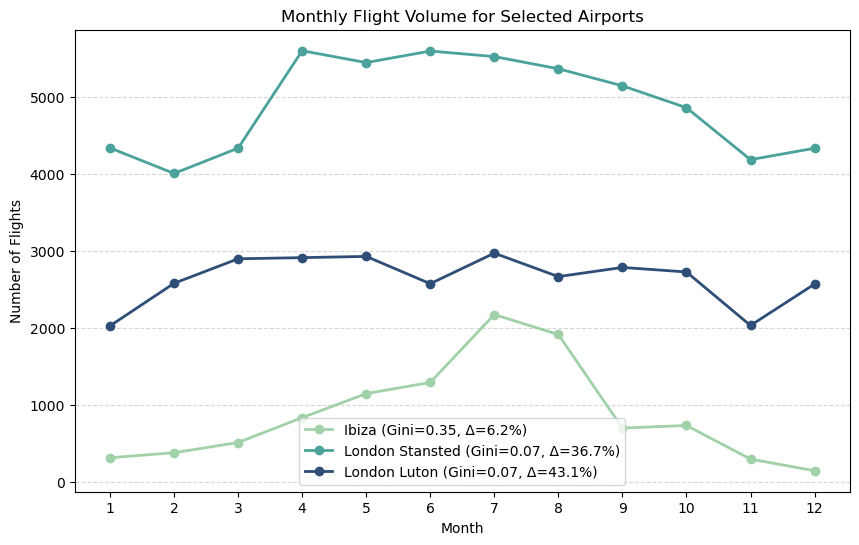

In [ ]:
selected_icaos = ["LEIB", "EGSS", "EGGW"]
airport_names = {"LEIB": "Ibiza", "EGSS": "London Stansted", "EGGW": "London Luton"}

gini_map = top_10_airports_data.set_index("ICAO")["gini"].to_dict()
change_rate_map = top_10_airports_data.set_index("ICAO")["change_rate"].to_dict()

colors = get_color_palette(3, reverse=False)

plt.figure(figsize=(10, 6))
for idx, icao in enumerate(selected_icaos):
    monthly_counts = (
        flights_cleaned[
            (flights_cleaned["adep"] == icao) | (flights_cleaned["ades"] == icao)
        ]
        .groupby("month")
        .size()
        .reindex(range(1, 13), fill_value=0)
    )
    gini = gini_map.get(icao, None)
    change_rate = change_rate_map.get(icao, None)
    label = airport_names[icao]

    if gini is not None and change_rate is not None:
        label += f" (Gini={gini:.2f}, Δ={change_rate:.1f}%)"
    plt.plot(
        monthly_counts.index,
        monthly_counts.values,
        marker="o",
        label=label,
        color=colors[idx], 
        linewidth=2
    )

plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.title("Monthly Flight Volume for Selected Airports")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### Flight Seasonality Analysis


In [44]:
# merge the airport data with the weather data

MGWR_data = airport_gini[['ICAO', 'gini', 'Latitude', 'Longitude']].copy()

# merge airport data with passenger, GDP, precipitation, and temperature data
MGWR_data = MGWR_data.merge(
    airport_data[['ICAO', 'passenger', 'Elevation', 'Country', 'Precipitation', 'Temperature']],
    on='ICAO', how='left'
)
MGWR_data = MGWR_data.merge(
    GDP[['Country', 'Y2024']],
    on='Country', how='left'
)
MGWR_data.rename(columns={'Y2024': 'GDP'}, inplace=True)
MGWR_data = MGWR_data.dropna()


In [45]:
print(MGWR_data['Latitude'].apply(lambda x: isinstance(x, np.ndarray)).value_counts())
print(MGWR_data['Longitude'].apply(lambda x: isinstance(x, np.ndarray)).value_counts())

Latitude
False    294
Name: count, dtype: int64
Longitude
False    294
Name: count, dtype: int64


Optimal Bandwidth: 125.0
Model type                                                         Gaussian
Number of observations:                                                 294
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            219.680
Log-likelihood:                                                    -374.331
AIC:                                                                760.662
AICc:                                                               763.054
BIC:                                                              -1417.191
R2:                                                                   0.253
Adj. R2:                                                              0.240

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---

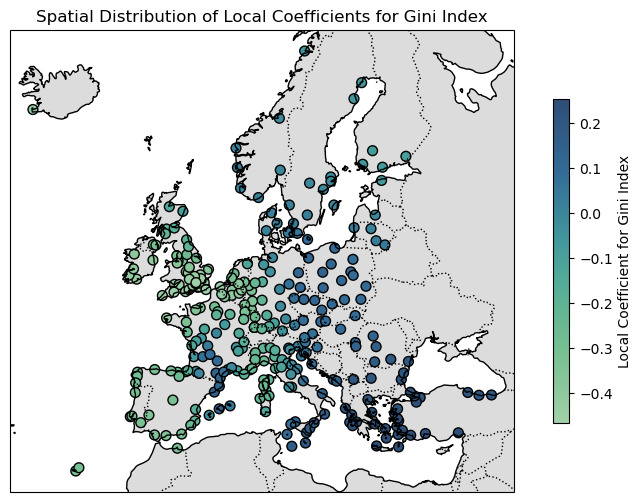

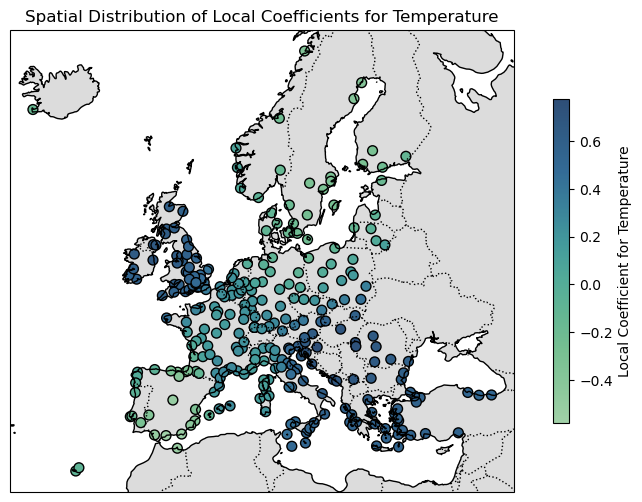

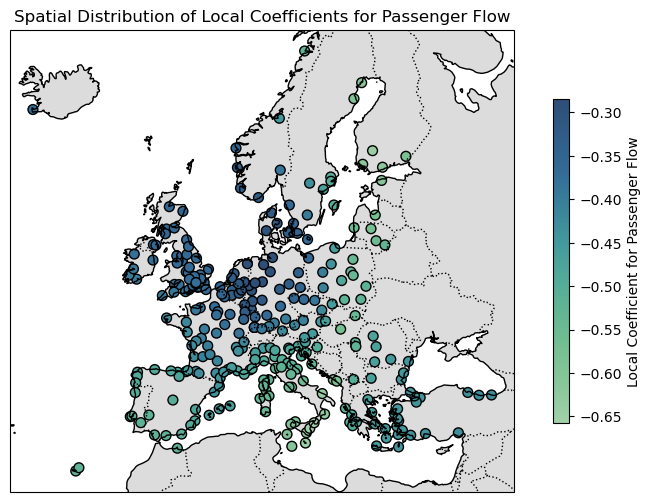

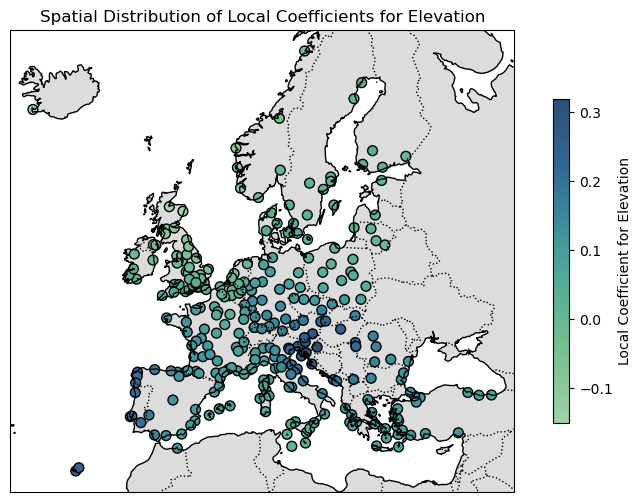

In [47]:
# define the dependent and independent variables
y = MGWR_data['gini'].values.reshape((-1, 1))
X = MGWR_data[['Precipitation', 'Temperature', 'passenger', 'Elevation','GDP']].values

# standardize the data
scaler = StandardScaler()
MGWR_data[['gini', 'Precipitation', 'Temperature', 'passenger', 'Elevation','GDP']] = scaler.fit_transform(
    MGWR_data[['gini', 'Precipitation', 'Temperature', 'passenger', 'Elevation','GDP']]
)

#bandwidth selection
coords = MGWR_data[['Longitude', 'Latitude']].values
selector = Sel_BW(coords, y, X)
bandwidth = selector.search()
print(f"Optimal Bandwidth: {bandwidth}")

# fit the MGWR model
model = GWR(coords, y, X, bw=bandwidth)
results = model.fit()

print(results.summary())

# extract the local parameters and add them to the data
local_params = results.params
param_columns = ['local_coef_gini', 'local_coef_temp', 'local_coef_passenger', 'local_coef_elevation']
name_map = {
    'local_coef_gini': 'Gini Index',
    'local_coef_temp': 'Temperature',
    'local_coef_passenger': 'Passenger Flow',
    'local_coef_elevation': 'Elevation'
}

for i, col in enumerate(param_columns):
    MGWR_data[col] = local_params[:, i + 1]
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.Mercator()})
    ax.add_feature(cfeature.LAND, facecolor='gainsboro')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    sc = ax.scatter(
        MGWR_data['Longitude'],
        MGWR_data['Latitude'],
        c=MGWR_data[col],
        cmap=get_cmap(reverse=False),
        s=50,
        edgecolor='k',
        transform=ccrs.PlateCarree()
    )
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, label=f'Local Coefficient for {name_map[col]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Spatial Distribution of Local Coefficients for {name_map[col]}')
    plt.show()